In [3]:
import csv
import os

import cv2
import numpy as np

samples = []
with open('data/driving_log.csv') as csv_file:
    reader = csv.reader(csv_file)
    correction = 0.2*np.array([0, +1, -1])
    for line in reader:        
        for view in range(3):
            for flipped in [1, -1]:
                source_path = os.path.basename(line[view].strip())
                file_path = os.path.join('data', 'IMG', source_path)
                if len(line[4]) == 1:
                    angle = float(line[3])
                else:
                    angle = float(line[3] + '.' + line[4])
                    
                data = {
                    'path': file_path,
                    'angle': flipped * (angle + correction[view]),
                    'flipped': flipped
                }
                samples.append(data)
                
samples = samples[::5]

IndexError: list index out of range

In [17]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for sample in batch_samples:
                file_path = sample['path']
                image = cv2.imread(file_path)
                flipped = sample['flipped']
                measurement = sample['angle']
                
                if flipped == -1:
                    images.append(cv2.flip(image, 1))
                else:
                    images.append(image)
                measurements.append(measurement)
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield shuffle(X_train, y_train)
       
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)

In [18]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))

#LeNet
#model.add(Convolution2D(6, 5, 5, activation='relu'))
#model.add(MaxPooling2D())
#model.add(Convolution2D(6, 5, 5, activation='relu'))
#model.add(MaxPooling2D())
#model.add(Flatten())
#model.add(Dense(128))
#model.add(Dense(84))
#model.add(Dense(1))

#Nvidia
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

print (model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 160, 320, 3)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
cropping2d_4 (Cropping2D)        (None, 65, 320, 3)    0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 31, 158, 24)   1824        cropping2d_4[0][0]               
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 14, 77, 36)    21636       convolution2d_16[0][0]           
___________________________________________________________________________________________

In [21]:
history_object = model.fit_generator(train_generator,
                                     samples_per_epoch=len(train_samples),
                                     validation_data=validation_generator,
                                     nb_val_samples=len(validation_samples), 
                                     nb_epoch=3)

Epoch 1/5
21335/21335 [==============================] - 244s - loss: 0.0075 - val_loss: 0.0089

dict_keys(['val_loss', 'loss'])


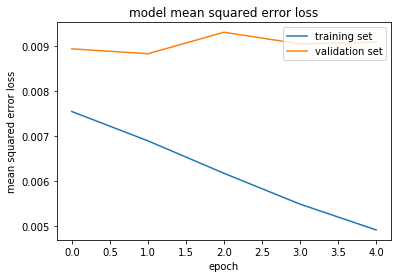

In [22]:
print(history_object.history.keys())

import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')